In [123]:
!pip install pyarrow fastparquet

# 3 урок: Методы решения проблем при работе с TimeSeries данными

In [332]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

# Что будем делать?

- обучим модель спроса и оценим ее
- обсудим проблемы при работе с TimeSeries данными
- улучшим качество модели путем решения этих проблем

# Задача:

Вам нужно предоставить модель спроса в качестве первого этапа пайплайна динамического ценообразования. Горизонт предсказания - 7 дней вперед. Затем эту модель будут использовать для предсказания спроса при разных ценах.

# Данные

<b>sales_cut.parquet</b> - таблица с историей продаж и признаками для модели c 01.01.2021 по 30.06.2021

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `price`        | цена за дату по товару                                                                   |
| `quantity`     | количество проданного товара за дату                                                     |
| `group`        | категория товара                                                                         |
| `promo`        | название промо для даты                                                                  |
| `feature`      | признак                                                                                  |
| `ds`           | дата                                                                                     |

In [333]:
df = pd.read_parquet("./hm/sales.parquet")
cat_df = pd.read_parquet("./hm/categories.parquet")
promo_df = pd.read_parquet("./hm/promo.parquet")

df['ds'] = df['ds'].astype('str')
promo_df['ds'] = promo_df['ds'].astype('str')

df = df.merge(cat_df, on=['sku_id']).merge(promo_df, on=['ds'])

df['discount'] = df['discount'] * 100

df.head()

,sku_id,orders_num,discount,ds,group_1,group_2,promo
0,283,169.0,0.0,20230601,100000,100006,no
1,393,159.0,1.0,20230601,100009,100021,no
2,235,1061.0,3.0,20230601,100003,100032,no
3,215,630.0,0.0,20230601,100011,100020,no
4,43,198.0,1.0,20230601,100006,100023,no


# Обучение модели

In [334]:
# Функция для подсчета MAPE
def calculate_mape(
    df: pd.DataFrame,
    true: str = "orders_num",
    pred: str = "pred_orders_num",
) -> float:
    df_copied = df.copy(deep=True)
    df_copied = df_copied[df_copied[true] > 0]
    df_copied["mape"] = np.abs(df_copied[true] - df_copied[pred]) / df_copied[true]
    return df_copied["mape"].mean()

In [335]:
from sklearn.model_selection import TimeSeriesSplit
from typing import Tuple

# Функция для TimeSeries кросс-валидации
def get_dfs(
    df: pd.DataFrame,
    n_splits: int,
    test_size: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Возвращает 3 датасета: трейн, вал, тест
    """
    # Уникальные даты в датасете
    dates = pd.Series(sorted(df["ds"].unique()))
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    # Проход по разделениям
    for split_id, (train_idxs, test_idxs) in enumerate(tscv.split(dates)):
        train_dates = dates.iloc[train_idxs]
        test_dates = dates.iloc[test_idxs]
        val_dates = train_dates[-test_size:]
        train_dates = train_dates[:-test_size]
        
        logger.info(f"===== SPLIT {split_id} =====")
        logger.info(f"Train: {train_dates.min()} - {train_dates.max()}, size: {train_dates.shape[0]}")
        logger.info(f"Validation: {val_dates.min()} - {val_dates.max()}, size: {val_dates.shape[0]}")
        logger.info(f"Test: {test_dates.min()} - {test_dates.max()}, size: {test_dates.shape[0]}")

        train_df = df[df["ds"].isin(train_dates)]
        val_df = df[df["ds"].isin(val_dates)]
        test_df = df[df["ds"].isin(test_dates)]
        yield train_df, val_df, test_df

In [336]:
from catboost import CatBoost, Pool
from typing import List, Dict, Any, Optional

# Функция для преобразования данных на вход Catboost
def prepare_pool(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: Optional[str] = None,
) -> Pool:
    data = df[flt_features + cat_features]
    pool = Pool(
        data=data,
        label=df[target] if target is not None else None,
        cat_features=cat_features,
    )
    return pool
    
# Функция для тренировки модели спроса
def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
    train_params: Dict[str, Any],
) -> CatBoost:
    train_data = train_df[flt_features + cat_features]
    train_pool = prepare_pool(
        df=train_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    val_pool = prepare_pool(
        df=val_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    model = CatBoost(params=train_params).fit(X=train_pool, eval_set=val_pool)
    return model

# Функция для предсказания спроса с обученной моделью
def predict(
    df: pd.DataFrame,
    model: CatBoost,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
) -> List[float]:
    pool = prepare_pool(
        df=df,
        flt_features=flt_features,
        cat_features=cat_features,
    )
    preds = model.predict(data=pool)
    return preds

In [337]:
from typing import List, Dict, Any, Callable, Optional

# Пайплайн для валидации модели
def run_pipeline(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    train_params: Dict[str, Any],
    target: str,
    n_splits: int,
    test_size: int,
    preprocess_train: Optional[Callable] = None,
    preprocess_train_params: Optional[Dict[str, Any]] = None,
) -> float:
    mapes = []
    for train_df, val_df, test_df in get_dfs(
        df=df,
        n_splits=n_splits,
        test_size=test_size,
    ):
        if preprocess_train is not None and preprocess_train_params is not None:
            train_df = preprocess_train(df=train_df, **preprocess_train_params)
        # Тренируем модель
        model = train_model(
            train_df=train_df,
            val_df=val_df,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
            train_params=train_params,
        )
        # Смотрим на важность фичей
        logger.info(model.get_feature_importance(prettified=True).head(10))
        # Предсказываем с помощью обученной модели
        test_df["pred_orders_num"] = predict(
            df=test_df,
            model=model,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
        )
        # считаем качество
        # лучше считать качество с учетом постпроцессинга (включая clip), но сейчас эти пренебрежём
        mape = calculate_mape(
            df=test_df,
            true="orders_num",
            pred="pred_orders_num",
        )
        mapes.append(mape)
        logger.info(f"MAPE: {mape}")

    mean_mape = np.mean(mapes)
    logger.info(f"Mean MAPE: {mean_mape}")
    return mean_mape, model

In [338]:
metric_result = {}

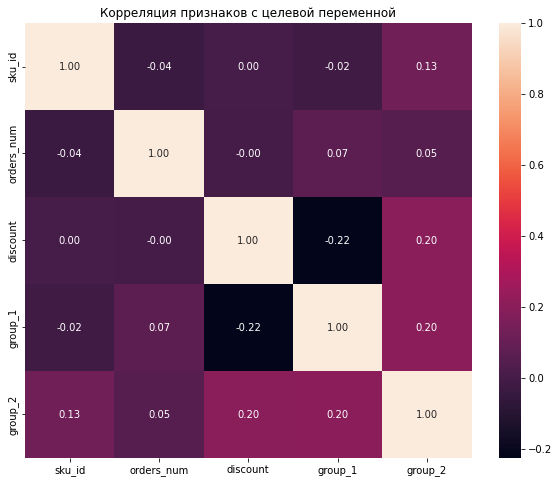

In [339]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

# Проблема #1 Утечка данных (Data Leakage)

### Лаги и окна
- в лагах / окнах закладывать шифт, равный кол-ву времени, которое нужно предсказать:
    - если предсказывать нужно на 7 дней вперед, нельзя использовать лаг "вчера", так как это значение мы будет знать только для 1 дня, а для 6 других будут пропуски
- окна считаются без учета правой границы периода (без учета текущего дня), если на момент предсказания мы не будем знать информацию об этом значении:
    - окно на основе таргета
- для консистентности данных правильнее считать лаги / окна на основе timestamp, учитывая пропуски:
    - день при лаге 7 дней назад должен быть таким же днем недели, что и текущий, даже если между этими днями вообще не было значений

In [340]:
# Расчет оконных функций
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(lambda x: x.asfreq("1D").rolling(window=window, closed="left", min_periods=0).mean().shift(shift))
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df

In [341]:
# Добавим в модель средние значения по количеству товаров за окно
for window in [1, 7, 14, 21, 28]:
    df = calc_rolling_window(
        df=df,
        window=window,
        col="orders_num",
        lvl="sku_id",
        shift=14,
    )

In [342]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "discount",
    "rolling_orders_num_w_1",
    "rolling_orders_num_w_7",
    "rolling_orders_num_w_14",
    "rolling_orders_num_w_21",
    "rolling_orders_num_w_28",
]
CAT_FEATURES = [
    "sku_id",
    "group_1",
    "group_2",
    "promo",
]
TARGET = "orders_num"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape, model = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)
metric_result["После добавления оконных функций"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20230601 - 20231008, size: 130
INFO:model:Validation: 20231009 - 20231105, size: 28
INFO:model:Test: 20231106 - 20231203, size: 28


0:	learn: 0.2645572	test: 0.2911368	best: 0.2911368 (0)	total: 22.6ms	remaining: 22.5s
100:	learn: 0.2098769	test: 0.2181658	best: 0.2152747 (79)	total: 1.82s	remaining: 16.2s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_28    34.430292
1  rolling_orders_num_w_21    25.238932
2  rolling_orders_num_w_14    18.185266
3                   sku_id     7.985386
4   rolling_orders_num_w_7     5.424801
5                  group_2     5.096936
6   rolling_orders_num_w_1     3.113063
7                 discount     0.267748
8                    promo     0.202040
9                  group_1     0.055536
INFO:model:MAPE: 0.27583889510698756
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20230601 - 20231105, size: 158
INFO:model:Validation: 20231106 - 20231203, size: 28
INFO:model:Test: 20231204 - 20231231, size: 28


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2152746722
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 0.2717788	test: 0.3423413	best: 0.3423413 (0)	total: 29.7ms	remaining: 29.7s


100:	learn: 0.2141016	test: 0.2798185	best: 0.2762307 (65)	total: 2.09s	remaining: 18.6s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_28    30.721097
1  rolling_orders_num_w_21    21.429392
2  rolling_orders_num_w_14    18.356316
3                   sku_id    10.074018
4   rolling_orders_num_w_7     8.413195
5                  group_2     5.968660
6   rolling_orders_num_w_1     3.787429
7                  group_1     0.792121
8                    promo     0.378142
9                 discount     0.079629
INFO:model:MAPE: 0.2676204477604898
INFO:model:Mean MAPE: 0.2717296714337387


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2762307188
bestIteration = 65

Shrink model to first 66 iterations.


# Проблема #2 Выбросы

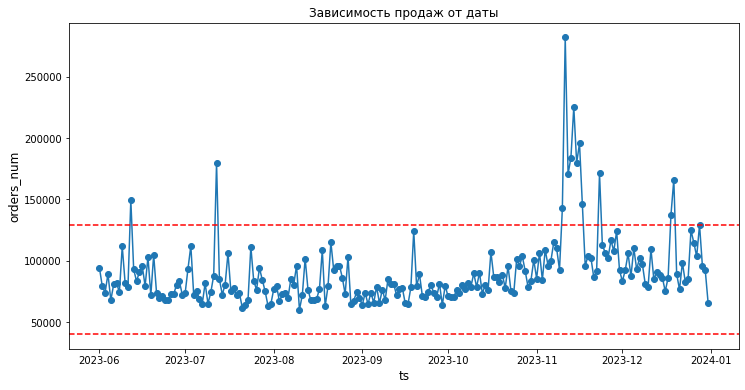

In [343]:
# Нарисуем график зависимости продаж от даты
plot_df = df.copy(deep=True).groupby("ds").agg({"orders_num": "sum"}).reset_index()
plot_df["ts"] = pd.to_datetime(plot_df["ds"].astype(str))

# Вычисление квантилей и IQR
q1 = plot_df['orders_num'].quantile(0.25)
q3 = plot_df['orders_num'].quantile(0.75)
iqr = q3 - q1

# Определение пределов для 1.5 IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

plt.figure(figsize=(12, 6))
plt.plot(plot_df["ts"], plot_df["orders_num"], marker='o')
plt.xlabel("ts", fontsize=12)
plt.ylabel("orders_num", fontsize=12)
plt.title("Зависимость продаж от даты", fontsize=12)

plt.axhline(y=lower_bound, color='r', linestyle='--')
plt.axhline(y=upper_bound, color='r', linestyle='--')

plt.show()

In [344]:
def drop_outliers(
    df: pd.DataFrame,
    lvl: str,
    low_quantile: float,
    high_quantile: float,
) -> pd.DataFrame:
    # Убираем выбросы с помощью квантильного размаха
    df = df.merge(
        df.groupby(lvl)["orders_num"].quantile(low_quantile).reset_index().rename(columns={"orders_num": "q25"}),
        how="left",
        on=lvl,
    )
    df = df.merge(
        df.groupby(lvl)["orders_num"].quantile(high_quantile).reset_index().rename(columns={"orders_num": "q75"}),
        how="left",
        on=lvl,
    )
    df = df[
        (df["orders_num"] < df["q75"] + 1.5 * (df["q75"] - df["q25"]))
        & (df["orders_num"] > df["q25"] - 1.5 * (df["q75"] - df["q25"]))
    ]
    return df

In [345]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "discount",
    "rolling_orders_num_w_1",
    "rolling_orders_num_w_7",
    "rolling_orders_num_w_14",
    "rolling_orders_num_w_21",
    "rolling_orders_num_w_28",
]
CAT_FEATURES = [
    "group_2",
    "group_1",
    "promo",
]
TARGET = "orders_num"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape, model = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    preprocess_train=drop_outliers,
    preprocess_train_params={
        "lvl": "sku_id",
        "low_quantile": 0.25,
        "high_quantile": 0.75,
    }
)
metric_result["После удаление выбросов"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20230601 - 20231008, size: 130
INFO:model:Validation: 20231009 - 20231105, size: 28
INFO:model:Test: 20231106 - 20231203, size: 28


0:	learn: 0.2380581	test: 0.2873271	best: 0.2873271 (0)	total: 22.1ms	remaining: 22.1s
100:	learn: 0.1799545	test: 0.2142190	best: 0.2138924 (93)	total: 1.77s	remaining: 15.7s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_21    34.629521
1  rolling_orders_num_w_28    29.281532
2  rolling_orders_num_w_14    18.867556
3   rolling_orders_num_w_7     7.436810
4                  group_2     5.172666
5   rolling_orders_num_w_1     3.952546
6                  group_1     0.547962
7                 discount     0.064041
8                    promo     0.047366
INFO:model:MAPE: 0.27563185015578734
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20230601 - 20231105, size: 158
INFO:model:Validation: 20231106 - 20231203, size: 28
INFO:model:Test: 20231204 - 20231231, size: 28


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2138923999
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 0.2433921	test: 0.3408736	best: 0.3408736 (0)	total: 25.5ms	remaining: 25.5s


100:	learn: 0.1841854	test: 0.2860739	best: 0.2750863 (48)	total: 2.07s	remaining: 18.4s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_28    37.078527
1  rolling_orders_num_w_14    27.401074
2  rolling_orders_num_w_21    22.862823
3   rolling_orders_num_w_7    10.281232
4   rolling_orders_num_w_1     2.013480
5                 discount     0.258737
6                    promo     0.104127
7                  group_2     0.000000
8                  group_1     0.000000
INFO:model:MAPE: 0.2560586514128263
INFO:model:Mean MAPE: 0.2658452507843068


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2750863294
bestIteration = 48

Shrink model to first 49 iterations.


# Проблема #3 Неправильная предобработка ds-признаков

In [346]:
df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
df["day_of_week_sin"] = np.sin((df["day_of_week"] - 1) * (2.0 * np.pi / 7))
df["day_of_week_cos"] = np.cos((df["day_of_week"] - 1) * (2.0 * np.pi / 7))

In [347]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "discount",
    "rolling_orders_num_w_1",
    "rolling_orders_num_w_7",
    "rolling_orders_num_w_14",
    "rolling_orders_num_w_21",
    "rolling_orders_num_w_28",
    "day_of_week_sin",
    "day_of_week_cos",
]
CAT_FEATURES = [
    "group_1",
    "group_2",
    "promo",
]
TARGET = "orders_num"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}
TEST_SIZE = 28
N_SPLITS = 2
mape, model = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    preprocess_train=drop_outliers,
    preprocess_train_params={
        "lvl": "sku_id",
        "low_quantile": 0.25,
        "high_quantile": 0.75,
    }
)
metric_result["После добавления правильных ds-фич"] = mape

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20230601 - 20231008, size: 130
INFO:model:Validation: 20231009 - 20231105, size: 28
INFO:model:Test: 20231106 - 20231203, size: 28


0:	learn: 0.2380351	test: 0.2890235	best: 0.2890235 (0)	total: 21.8ms	remaining: 21.7s
100:	learn: 0.1800197	test: 0.2130823	best: 0.2130683 (99)	total: 1.71s	remaining: 15.2s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_28    35.833291
1  rolling_orders_num_w_21    29.835898
2  rolling_orders_num_w_14    19.561395
3   rolling_orders_num_w_7     7.208606
4                  group_2     4.390448
5   rolling_orders_num_w_1     2.014742
6                  group_1     0.806338
7                    promo     0.224966
8          day_of_week_sin     0.054327
9                 discount     0.043496
INFO:model:MAPE: 0.2751253509182363
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20230601 - 20231105, size: 158
INFO:model:Validation: 20231106 - 20231203, size: 28
INFO:model:Test: 20231204 - 20231231, size: 28


200:	learn: 0.1831009	test: 0.2148437	best: 0.2130074 (105)	total: 3.08s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.213007398
bestIteration = 105

Shrink model to first 106 iterations.


0:	learn: 0.2439913	test: 0.3417517	best: 0.3417517 (0)	total: 23.5ms	remaining: 23.4s
100:	learn: 0.1841361	test: 0.2934517	best: 0.2833128 (23)	total: 1.91s	remaining: 17s


INFO:model:                Feature Id  Importances
0  rolling_orders_num_w_28    48.862808
1  rolling_orders_num_w_21    27.468297
2   rolling_orders_num_w_7    14.816127
3  rolling_orders_num_w_14     5.052504
4   rolling_orders_num_w_1     3.699813
5          day_of_week_cos     0.075937
6                 discount     0.013517
7          day_of_week_sin     0.010998
8                  group_1     0.000000
9                  group_2     0.000000
INFO:model:MAPE: 0.24641771701479376
INFO:model:Mean MAPE: 0.26077153396651503


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2833128417
bestIteration = 23

Shrink model to first 24 iterations.


# Проблема #5 Пропуски в данных

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46376 entries, 0 to 46375
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sku_id                   46376 non-null  int64  
 1   orders_num               46376 non-null  float64
 2   discount                 46376 non-null  float64
 3   ds                       46376 non-null  object 
 4   group_1                  46376 non-null  int64  
 5   group_2                  46376 non-null  int64  
 6   promo                    46376 non-null  object 
 7   rolling_orders_num_w_1   38764 non-null  float64
 8   rolling_orders_num_w_7   43088 non-null  float64
 9   rolling_orders_num_w_14  43088 non-null  float64
 10  rolling_orders_num_w_21  43088 non-null  float64
 11  rolling_orders_num_w_28  43088 non-null  float64
 12  day_of_week              46376 non-null  int64  
 13  day_of_week_sin          46376 non-null  float64
 14  day_of_week_cos       

# Итог

In [349]:
for stage, metric_value in metric_result.items():
    print(f"{stage} MAPE={round(metric_value * 100)}%")

После добавления оконных функций MAPE=27%
После удаление выбросов MAPE=27%
После добавления правильных ds-фич MAPE=26%


# Что еще?

- биннинг = разделение признаков на бины
- подбор гиперпараметров
    - optuna, hyperopt, Google Vizier...
- добавление новых фичей
    - окна
    - лаги
    - корреляции
- нормализация и масштабирование данных
    - Min-Max Scaling
    - Standard Scaling
- преобразование признака в явный сигнал модели
    - если важно предсказать, как изменится спрос на изменение цены  - лучше использовать признак "изменение цены" вместо просто "цена"
- работа с категориальными признаками
- фильтрация неважных семплов
    - если важно предсказать, как изменится спрос на изменение цены, то можно выкинуть часть семплов, где цена не меняется
- учитывание тренда
    - если модель не учитывает тренд, то можно использовать домножение на коэффициент тренда
- мало данных для обучения (нет 100%-х хорошо работающих методов аугментации данных, как в CV, из-за чего мы ограничены тем набором данных, что есть)

In [350]:
work_df = pd.read_csv('./hm/homework_3_1.csv')

work_df['ds'] = work_df['ds'].astype('str')

work_df = work_df.merge(cat_df, on=['sku_id']).merge(promo_df, on=['ds'])

work_df['discount'] = work_df['discount'] * 100

work_df

,sku_id,discount,orders_num,ds,group_1,group_2,promo
0,283,0.0,NaN,20240101,100000,100006,no
1,235,1.0,NaN,20240101,100003,100032,no
2,215,0.0,NaN,20240101,100011,100020,no
3,43,3.0,NaN,20240101,100006,100023,no
4,206,3.0,NaN,20240101,100002,100002,no
...,...,...,...,...,...,...,...
3030,186,1.0,NaN,20240114,100009,100029,no
3031,337,1.0,NaN,20240114,100003,100032,no
3032,300,2.0,NaN,20240114,100006,100007,no
3033,377,1.0,NaN,20240114,100002,100002,no


In [351]:
df = pd.read_parquet("./hm/sales.parquet")
cat_df = pd.read_parquet("./hm/categories.parquet")
promo_df = pd.read_parquet("./hm/promo.parquet")

df['ds'] = df['ds'].astype('str')
promo_df['ds'] = promo_df['ds'].astype('str')

df = df.merge(cat_df, on=['sku_id']).merge(promo_df, on=['ds'])

df['discount'] = df['discount'] * 100

work_df = df.append(work_df)
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49411 entries, 0 to 3034
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sku_id      49411 non-null  int64  
 1   orders_num  46376 non-null  float64
 2   discount    49411 non-null  float64
 3   ds          49411 non-null  object 
 4   group_1     49411 non-null  int64  
 5   group_2     49411 non-null  int64  
 6   promo       49411 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [352]:
for window in [1, 7, 14, 21, 28]:
    work_df = calc_rolling_window(
        df=work_df,
        window=window,
        col="orders_num",
        lvl="sku_id",
        shift=14,
    )

In [353]:
work_df["day_of_week"] = pd.DatetimeIndex(work_df["ds"]).day_of_week
work_df["day_of_week_sin"] = np.sin((work_df["day_of_week"] - 1) * (2.0 * np.pi / 7))
work_df["day_of_week_cos"] = np.cos((work_df["day_of_week"] - 1) * (2.0 * np.pi / 7))

In [354]:
work_df['orders_num'] = predict(
    df=work_df,
    model=model,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    target=TARGET
)

work_df

,sku_id,orders_num,discount,ds,group_1,group_2,promo,rolling_orders_num_w_1,rolling_orders_num_w_7,rolling_orders_num_w_14,rolling_orders_num_w_21,rolling_orders_num_w_28,day_of_week,day_of_week_sin,day_of_week_cos
0,2,185.620694,2.0,20230601,100001,100001,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
1,3,185.620694,1.0,20230601,100002,100002,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
2,4,185.620694,3.0,20230601,100003,100003,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
3,5,185.620694,1.0,20230601,100004,100004,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
4,8,185.826194,0.0,20230601,100006,100007,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49406,393,171.895721,0.0,20240114,100009,100021,no,162.0,160.714286,163.142857,166.950000,169.423077,6,-0.974928,-0.222521
49407,397,172.962510,0.0,20240114,100004,100022,no,163.0,175.142857,168.857143,166.700000,166.814815,6,-0.974928,-0.222521
49408,398,201.405409,1.0,20240114,100000,100000,no,193.0,280.857143,254.846154,236.631579,254.240000,6,-0.974928,-0.222521
49409,400,181.163778,2.0,20240114,100001,100024,no,281.0,226.000000,204.083333,192.666667,199.750000,6,-0.974928,-0.222521


In [355]:
striped_work_df = work_df[work_df['ds'].isin([
    '20240101',
    '20240102',
    '20240103',
    '20240104',
    '20240105',
    '20240106',
    '20240107',
    '20240108',
    '20240109',
    '20240110',
    '20240111',
    '20240112',
    '20240113',
    '20240114'
])]

striped_work_df = striped_work_df[[
    'sku_id',
    'discount',
    'orders_num',
    'ds'
]]

striped_work_df['discount'] = striped_work_df['discount'] / 100

striped_work_df

,sku_id,discount,orders_num,ds
46376,2,0.02,185.554229,20240101
46377,3,0.01,175.481623,20240101
46378,4,0.03,355.037336,20240101
46379,5,0.01,335.040659,20240101
46380,12,0.00,188.889021,20240101
...,...,...,...,...
49406,393,0.00,171.895721,20240114
49407,397,0.00,172.962510,20240114
49408,398,0.01,201.405409,20240114
49409,400,0.02,181.163778,20240114


In [356]:
striped_work_df.to_csv('./to_karp_3_1.csv', index=False)

# Таблица спроса

In [434]:
work_df = pd.read_csv('./temp_3.csv')
work_df = work_df.drop('Unnamed: 0', axis=1)

work_df['ds'] = work_df['ds'].astype('str')

work_df = work_df.merge(cat_df, on=['sku_id']).merge(promo_df, on=['ds'])

work_df['discount'] = work_df['discount'] * 100

work_dfs = [
    work_df[work_df['discount'] == x] for x in range(-5, 6)
]

In [435]:
df = pd.read_parquet("./hm/sales.parquet")
cat_df = pd.read_parquet("./hm/categories.parquet")
promo_df = pd.read_parquet("./hm/promo.parquet")

df['ds'] = df['ds'].astype('str')
promo_df['ds'] = promo_df['ds'].astype('str')

df = df.merge(cat_df, on=['sku_id']).merge(promo_df, on=['ds'])

df['discount'] = df['discount'] * 100

tables = [
    df.append(work) for work in work_dfs
]
#work_df = df.append(work_df)
tables[0]

,sku_id,orders_num,discount,ds,group_1,group_2,promo
0,283,169.0,0.0,20230601,100000,100006,no
1,393,159.0,1.0,20230601,100009,100021,no
2,235,1061.0,3.0,20230601,100003,100032,no
3,215,630.0,0.0,20230601,100011,100020,no
4,43,198.0,1.0,20230601,100006,100023,no
...,...,...,...,...,...,...,...
37059,393,NaN,-5.0,20240114,100009,100021,no
37070,397,NaN,-5.0,20240114,100004,100022,no
37081,398,NaN,-5.0,20240114,100000,100000,no
37092,400,NaN,-5.0,20240114,100001,100024,no


In [436]:
for i in range(len(tables)):
    for window in [1, 7, 14, 21, 28]:
        tables[i] = calc_rolling_window(
            df=tables[i],
            window=window,
            col="orders_num",
            lvl="sku_id",
            shift=14,
        )

In [437]:
for i in range(len(tables)):
    tables[i]["day_of_week"] = pd.DatetimeIndex(tables[i]["ds"]).day_of_week
    tables[i]["day_of_week_sin"] = np.sin((tables[i]["day_of_week"] - 1) * (2.0 * np.pi / 7))
    tables[i]["day_of_week_cos"] = np.cos((tables[i]["day_of_week"] - 1) * (2.0 * np.pi / 7))

In [450]:
for i in range(len(tables)):
    tables[i]['orders_num'] = predict(
        df=tables[i],
        model=model,
        flt_features=FLT_FEATURES,
        cat_features=CAT_FEATURES,
        target=TARGET
    )

res = tables[0]
for i in range(1, len(tables)):
    tab = tables[i]
    tab['orders_num'] = tab['orders_num'] - i * 2
    res = res.append(tab)
res

,sku_id,orders_num,discount,ds,group_1,group_2,promo,rolling_orders_num_w_1,rolling_orders_num_w_7,rolling_orders_num_w_14,rolling_orders_num_w_21,rolling_orders_num_w_28,day_of_week,day_of_week_sin,day_of_week_cos
0,2,185.620694,2.0,20230601,100001,100001,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
1,3,185.620694,1.0,20230601,100002,100002,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
2,4,185.620694,3.0,20230601,100003,100003,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
3,5,185.620694,1.0,20230601,100004,100004,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
4,8,185.826194,0.0,20230601,100006,100007,no,NaN,NaN,NaN,NaN,NaN,3,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,393,151.911577,5.0,20240114,100009,100021,no,162.0,160.714286,163.142857,166.950000,169.423077,6,-0.974928,-0.222521
49746,397,152.885759,5.0,20240114,100004,100022,no,163.0,175.142857,168.857143,166.700000,166.814815,6,-0.974928,-0.222521
49747,398,181.795287,5.0,20240114,100000,100000,no,193.0,280.857143,254.846154,236.631579,254.240000,6,-0.974928,-0.222521
49748,400,161.553656,5.0,20240114,100001,100024,no,281.0,226.000000,204.083333,192.666667,199.750000,6,-0.974928,-0.222521


In [451]:
striped_work_df = res[res['ds'].isin([
    '20240101',
    '20240102',
    '20240103',
    '20240104',
    '20240105',
    '20240106',
    '20240107',
    '20240108',
    '20240109',
    '20240110',
    '20240111',
    '20240112',
    '20240113',
    '20240114'
])]

striped_work_df = striped_work_df[[
    'sku_id',
    'discount',
    'orders_num',
    'ds'
]]

striped_work_df['discount'] = striped_work_df['discount'] / 100

striped_work_df

,sku_id,discount,orders_num,ds
46376,2,-0.05,185.561942,20240101
46377,3,-0.05,175.613351,20240101
46378,4,-0.05,354.881666,20240101
46379,5,-0.05,334.544550,20240101
46380,8,-0.05,356.858794,20240101
...,...,...,...,...
49745,393,0.05,151.911577,20240114
49746,397,0.05,152.885759,20240114
49747,398,0.05,181.795287,20240114
49748,400,0.05,161.553656,20240114


In [452]:
striped_work_df.to_csv('./to_karp_3_2.csv', index=False)

# Максимизация

In [459]:
import math

In [460]:
third_sku = []
third_ds = []
third_discount = []

for group, data in striped_work_df.groupby(['ds', 'sku_id']):
    new_ds, new_sku = group
    val_data = data.values
    temp_order = -10
    temp_disc = -10
    for sku, discount, orders_num, ds in val_data:
        if orders_num > temp_order:
            temp_order = orders_num
            temp_disc = discount
        elif orders_num == temp_order and discount > temp_disc:
            temp_order = orders_num
            temp_disc = discount
    third_sku.append(new_sku)
    third_ds.append(new_ds)
    third_discount.append(temp_disc)

for_third = pd.DataFrame({
    'sku_id': third_sku,
    'ds': third_ds,
    'discount': third_discount
})
for_third

,sku_id,ds,discount
0,2,20240101,-0.05
1,3,20240101,-0.05
2,4,20240101,-0.05
3,5,20240101,-0.05
4,8,20240101,-0.05
...,...,...,...
3369,393,20240114,-0.05
3370,397,20240114,-0.05
3371,398,20240114,-0.05
3372,400,20240114,-0.05


In [462]:
for_third.to_csv('./to_karp_3_3.csv', index=False)